In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import dill

import csv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Загружаю целевую переменную

In [15]:
credit_target =  pd.concat(
                     [pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv', usecols=['id']),
                      pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv').drop(columns='id').astype('int8')],
                          axis=1)
credit_target.tail()

,id,flag
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0
2999999,2999999,0


# Циклом загружаю и соединяю все таблицы для работы из файлов Parquet

In [16]:
credit = pd.DataFrame()
for i in range(12):
  credit = pd.concat(
                     [credit,
                      pd.concat(
                                [pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq', columns=['id']),
                                 pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq').drop(columns='id').astype('int8')],
                          axis=1)]
                     )

In [18]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26162717 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19  is_z

In [19]:
credit.id.nunique()

3000000

# Написал функции, чтобы полностью выводить колонки, где есть пропущенные значения и бесконечность

In [20]:
def emptyval(dframe):
    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe.isnull()[col].sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

In [21]:
def infval(dframe):
    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe[col].isin([np.inf, -np.inf]).sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

In [22]:
emptyval(credit)

Done


# Циклом вывожу уникальные значения по всем колонкам, чтобы найти то, что можно удалить

In [10]:
for col, n in zip(credit, range(len(credit.columns))):
    print(f'{n}: {col}: {credit[col].unique()}')

0: id: [      0       1       2 ... 2999997 2999998 2999999]
1: rn: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58]
2: pre_since_opened: [18  4  5  3  2  1  7  8 15 14 10 13 12  0  6  9 19 17 11 16]
3: pre_since_confirmed: [ 9  1 12  0  7  3  4 14  6  8  5 16  2 10 17 11 13 15]
4: pre_pterm: [ 2 14  4  9 15 11  1 12 13  7  8  0 16 17 10  6  3  5]
5: pre_fterm: [ 3 14  8 12  2 13 10 15  6  0 11  9  1 16  7  5  4]
6: pre_till_pclose: [16 12  1 11 14  8  9 13  6 15  7  3  2  5  4 10  0]
7: pre_till_fclose: [10 12 11  7 14  8  1 13  5  3 15  2  6  9  0  4]
8: pre_loans_credit_limit: [11  0 12 10  4 15  2 16  1  6  3 14 19 13 18  5 17  8  7  9]
9: pre_loans_next_pay_summ: [3 0 2 5 4 1 6]
10: pre_loans_outstanding: [3 5 1 2 4]
11: pre_loans_total_overdue: [0 1]
12: pre_loans_max_overdue_sum: [2 1 3 0]
13: pre_loans_credit_cost_rate: [11  8  4  3 13  0  7  5  9  1 

# Группирую таблицу по идентификатору и суммирую все остальные значения

In [23]:
df = credit.groupby(['id'], as_index=False).sum().add_prefix('SUM_').reset_index(drop=True)

In [24]:
df.tail()

,SUM_id,SUM_rn,SUM_pre_since_opened,SUM_pre_since_confirmed,SUM_pre_pterm,SUM_pre_fterm,SUM_pre_till_pclose,SUM_pre_till_fclose,SUM_pre_loans_credit_limit,SUM_pre_loans_next_pay_summ,...,SUM_enc_paym_21,SUM_enc_paym_22,SUM_enc_paym_23,SUM_enc_paym_24,SUM_enc_loans_account_holder_type,SUM_enc_loans_credit_status,SUM_enc_loans_credit_type,SUM_enc_loans_account_cur,SUM_pclose_flag,SUM_fclose_flag
2999995,2999995,66,97,101,98,98,97,97,81,25,...,21,21,22,38,11,28,43,11,2,5
2999996,2999996,91,104,148,117,110,82,89,151,25,...,33,36,36,49,13,35,51,13,5,4
2999997,2999997,55,81,78,85,78,82,91,70,24,...,24,24,27,37,10,25,37,10,1,1
2999998,2999998,15,58,46,39,47,30,39,57,13,...,15,15,15,20,5,12,14,5,2,1
2999999,2999999,78,77,110,92,114,99,105,122,35,...,21,21,24,42,12,33,45,12,2,1


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 61 columns):
 #   Column                             Dtype
---  ------                             -----
 0   SUM_id                             int64
 1   SUM_rn                             int64
 2   SUM_pre_since_opened               int64
 3   SUM_pre_since_confirmed            int64
 4   SUM_pre_pterm                      int64
 5   SUM_pre_fterm                      int64
 6   SUM_pre_till_pclose                int64
 7   SUM_pre_till_fclose                int64
 8   SUM_pre_loans_credit_limit         int64
 9   SUM_pre_loans_next_pay_summ        int64
 10  SUM_pre_loans_outstanding          int64
 11  SUM_pre_loans_total_overdue        int64
 12  SUM_pre_loans_max_overdue_sum      int64
 13  SUM_pre_loans_credit_cost_rate     int64
 14  SUM_pre_loans5                     int64
 15  SUM_pre_loans530                   int64
 16  SUM_pre_loans3060                  int64
 17  SUM_pre_

In [69]:
df1 = df.drop(columns='SUM_id').astype('int16')
df1['id'] = df.SUM_id
df1.tail()

,SUM_rn,SUM_pre_since_opened,SUM_pre_since_confirmed,SUM_pre_pterm,SUM_pre_fterm,SUM_pre_till_pclose,SUM_pre_till_fclose,SUM_pre_loans_credit_limit,SUM_pre_loans_next_pay_summ,SUM_pre_loans_outstanding,...,SUM_enc_paym_22,SUM_enc_paym_23,SUM_enc_paym_24,SUM_enc_loans_account_holder_type,SUM_enc_loans_credit_status,SUM_enc_loans_credit_type,SUM_enc_loans_account_cur,SUM_pclose_flag,SUM_fclose_flag,id
2999995,66,97,101,98,98,97,97,81,25,35,...,21,22,38,11,28,43,11,2,5,2999995
2999996,91,104,148,117,110,82,89,151,25,40,...,36,36,49,13,35,51,13,5,4,2999996
2999997,55,81,78,85,78,82,91,70,24,32,...,24,27,37,10,25,37,10,1,1,2999997
2999998,15,58,46,39,47,30,39,57,13,18,...,15,15,20,5,12,14,5,2,1,2999998
2999999,78,77,110,92,114,99,105,122,35,33,...,21,24,42,12,33,45,12,2,1,2999999


In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 61 columns):
 #   Column                             Dtype
---  ------                             -----
 0   SUM_rn                             int16
 1   SUM_pre_since_opened               int16
 2   SUM_pre_since_confirmed            int16
 3   SUM_pre_pterm                      int16
 4   SUM_pre_fterm                      int16
 5   SUM_pre_till_pclose                int16
 6   SUM_pre_till_fclose                int16
 7   SUM_pre_loans_credit_limit         int16
 8   SUM_pre_loans_next_pay_summ        int16
 9   SUM_pre_loans_outstanding          int16
 10  SUM_pre_loans_total_overdue        int16
 11  SUM_pre_loans_max_overdue_sum      int16
 12  SUM_pre_loans_credit_cost_rate     int16
 13  SUM_pre_loans5                     int16
 14  SUM_pre_loans530                   int16
 15  SUM_pre_loans3060                  int16
 16  SUM_pre_loans6090                  int16
 17  SUM_pre_

# Создаю новые переменные в основном через отношения одних значений к другим, находя долю.
Например, 'pterm/fterm' - отношение планового количесвта дней с даты сбора данных до даты закртытия кредита к фактическому

In [27]:
def newfeatures(dframe):
    dframe2 = dframe.copy()

    dframe2['pterm/fterm'] = (dframe2.SUM_pre_pterm / dframe2.SUM_pre_fterm).astype('float16')
    dframe2['pclose/fclose'] = (dframe2.SUM_pre_till_pclose / dframe2.SUM_pre_till_fclose).astype('float16')
    dframe2['loans_next_pay_summ/loans_outstanding'] = (dframe2.SUM_pre_loans_next_pay_summ / dframe2.SUM_pre_loans_outstanding).astype('float16')
    dframe2['loans5/zero_loans5'] = (dframe2.SUM_pre_loans5 / dframe2.SUM_is_zero_loans5).astype('float16')
    dframe2['loans530/zero_loans530'] = (dframe2.SUM_pre_loans530 / dframe2.SUM_is_zero_loans530).astype('float16')
    dframe2['loans3060/zero_loans3060'] = (dframe2.SUM_pre_loans3060 / dframe2.SUM_is_zero_loans3060).astype('float16')
    dframe2['loans6090/zero_loans6090'] = (dframe2.SUM_pre_loans6090 / dframe2.SUM_is_zero_loans6090).astype('float16')
    dframe2['loans90/zero_loans90'] = (dframe2.SUM_pre_loans90 / dframe2.SUM_is_zero_loans90).astype('float16')

    dframe2['enc_paym_sum'] = dframe2.SUM_enc_paym_0
    for i in range(1, 25):
        dframe2['enc_paym_sum'] = (dframe2['enc_paym_sum'] + dframe2[f'SUM_enc_paym_{i}']).astype('int16')
    return dframe2

In [28]:
df2 = newfeatures(df1)

In [29]:
df2.tail()

,SUM_rn,SUM_pre_since_opened,SUM_pre_since_confirmed,SUM_pre_pterm,SUM_pre_fterm,SUM_pre_till_pclose,SUM_pre_till_fclose,SUM_pre_loans_credit_limit,SUM_pre_loans_next_pay_summ,SUM_pre_loans_outstanding,...,id,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
2999995,66,97,101,98,98,97,97,81,25,35,...,2999995,1.000000,1.000000,0.714355,7.332031,34.000000,5.000000,4.0,8.0,359
2999996,91,104,148,117,110,82,89,151,25,40,...,2999996,1.063477,0.921387,0.625000,6.500000,16.000000,5.417969,4.0,8.0,501
2999997,55,81,78,85,78,82,91,70,24,32,...,2999997,1.089844,0.900879,0.750000,6.667969,22.859375,5.000000,4.0,8.0,404
2999998,15,58,46,39,47,30,39,57,13,18,...,2999998,0.829590,0.769043,0.722168,6.000000,16.000000,6.250000,5.0,10.0,332
2999999,78,77,110,92,114,99,105,122,35,33,...,2999999,0.807129,0.942871,1.060547,6.546875,24.000000,5.453125,4.0,8.0,415


In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 70 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   SUM_rn                                 int16  
 1   SUM_pre_since_opened                   int16  
 2   SUM_pre_since_confirmed                int16  
 3   SUM_pre_pterm                          int16  
 4   SUM_pre_fterm                          int16  
 5   SUM_pre_till_pclose                    int16  
 6   SUM_pre_till_fclose                    int16  
 7   SUM_pre_loans_credit_limit             int16  
 8   SUM_pre_loans_next_pay_summ            int16  
 9   SUM_pre_loans_outstanding              int16  
 10  SUM_pre_loans_total_overdue            int16  
 11  SUM_pre_loans_max_overdue_sum          int16  
 12  SUM_pre_loans_credit_cost_rate         int16  
 13  SUM_pre_loans5                         int16  
 14  SUM_pre_loans530                       int16  
 15

In [31]:
emptyval(df2)

61: 1 pterm/fterm
62: 83 pclose/fclose
64: 910 loans5/zero_loans5
65: 500 loans530/zero_loans530
Done


In [32]:
infval(df2)

61: 10964 pterm/fterm
62: 4919 pclose/fclose
64: 14680 loans5/zero_loans5
65: 45057 loans530/zero_loans530
66: 11463 loans3060/zero_loans3060
67: 7194 loans6090/zero_loans6090
68: 8456 loans90/zero_loans90
Done


# Заменяю пустые и бесконечные значения на 0.

In [33]:
df3 = df2.replace([np.inf, -np.inf, np.nan], 0)

In [34]:
emptyval(df3)

Done


In [35]:
infval(df3)

Done


In [36]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 70 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   SUM_rn                                 int16  
 1   SUM_pre_since_opened                   int16  
 2   SUM_pre_since_confirmed                int16  
 3   SUM_pre_pterm                          int16  
 4   SUM_pre_fterm                          int16  
 5   SUM_pre_till_pclose                    int16  
 6   SUM_pre_till_fclose                    int16  
 7   SUM_pre_loans_credit_limit             int16  
 8   SUM_pre_loans_next_pay_summ            int16  
 9   SUM_pre_loans_outstanding              int16  
 10  SUM_pre_loans_total_overdue            int16  
 11  SUM_pre_loans_max_overdue_sum          int16  
 12  SUM_pre_loans_credit_cost_rate         int16  
 13  SUM_pre_loans5                         int16  
 14  SUM_pre_loans530                       int16  
 15

# Соединяю основную таблицу с целевой переменной

In [37]:
df4 = credit_target.merge(df3, on='id', how='inner')

In [38]:
df4.tail()

,id,flag,SUM_rn,SUM_pre_since_opened,SUM_pre_since_confirmed,SUM_pre_pterm,SUM_pre_fterm,SUM_pre_till_pclose,SUM_pre_till_fclose,SUM_pre_loans_credit_limit,...,SUM_fclose_flag,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
2999995,2999995,0,66,97,101,98,98,97,97,81,...,5,1.000000,1.000000,0.714355,7.332031,34.000000,5.000000,4.0,8.0,359
2999996,2999996,0,91,104,148,117,110,82,89,151,...,4,1.063477,0.921387,0.625000,6.500000,16.000000,5.417969,4.0,8.0,501
2999997,2999997,0,55,81,78,85,78,82,91,70,...,1,1.089844,0.900879,0.750000,6.667969,22.859375,5.000000,4.0,8.0,404
2999998,2999998,0,15,58,46,39,47,30,39,57,...,1,0.829590,0.769043,0.722168,6.000000,16.000000,6.250000,5.0,10.0,332
2999999,2999999,0,78,77,110,92,114,99,105,122,...,1,0.807129,0.942871,1.060547,6.546875,24.000000,5.453125,4.0,8.0,415


In [39]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 71 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   id                                     int64  
 1   flag                                   int8   
 2   SUM_rn                                 int16  
 3   SUM_pre_since_opened                   int16  
 4   SUM_pre_since_confirmed                int16  
 5   SUM_pre_pterm                          int16  
 6   SUM_pre_fterm                          int16  
 7   SUM_pre_till_pclose                    int16  
 8   SUM_pre_till_fclose                    int16  
 9   SUM_pre_loans_credit_limit             int16  
 10  SUM_pre_loans_next_pay_summ            int16  
 11  SUM_pre_loans_outstanding              int16  
 12  SUM_pre_loans_total_overdue            int16  
 13  SUM_pre_loans_max_overdue_sum          int16  
 14  SUM_pre_loans_credit_cost_rate         int16  
 15

# Строю графики распределений для определения выбросов и лишних значений

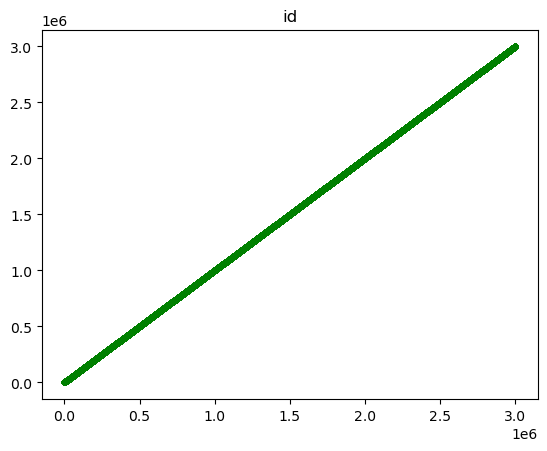

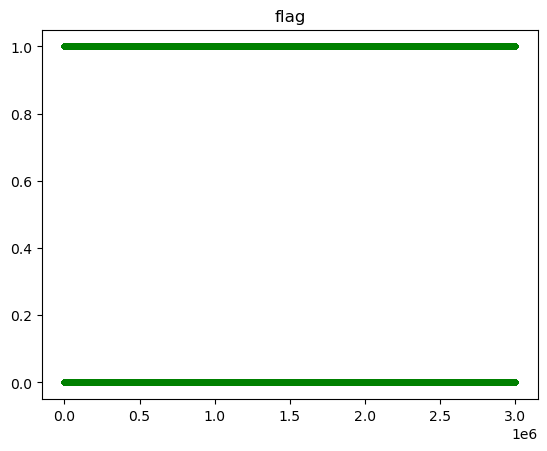

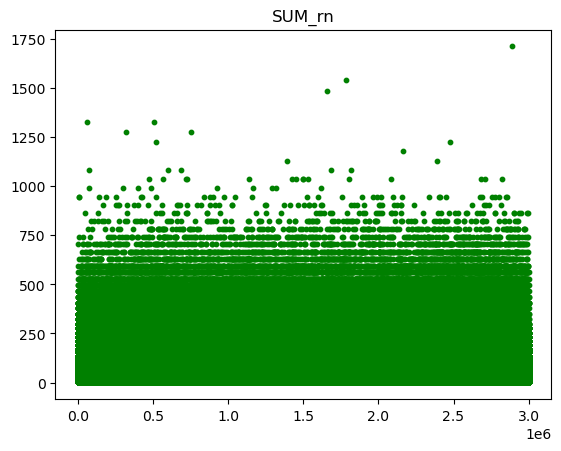

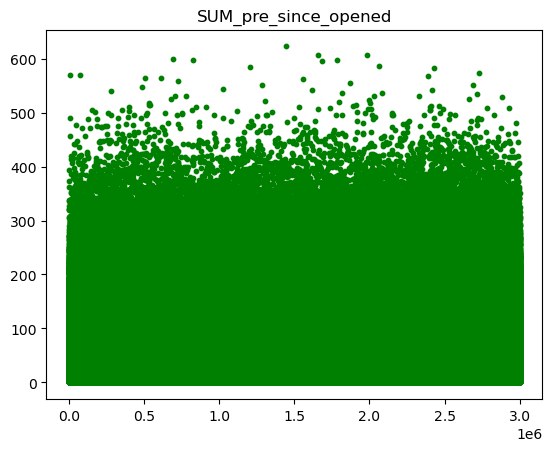

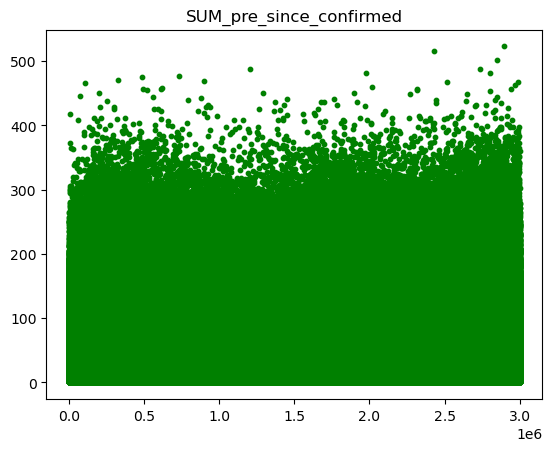

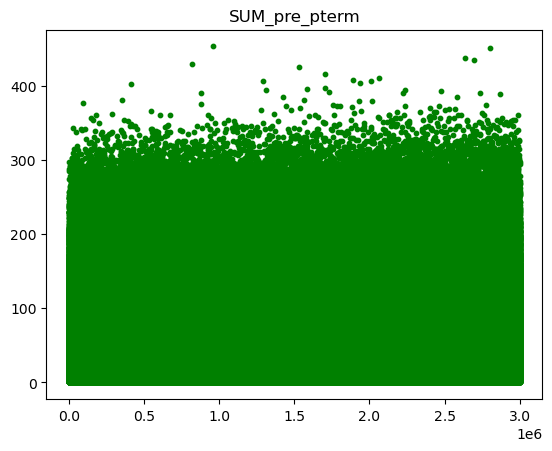

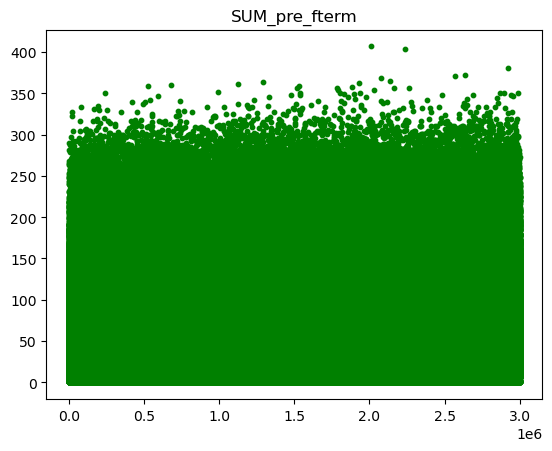

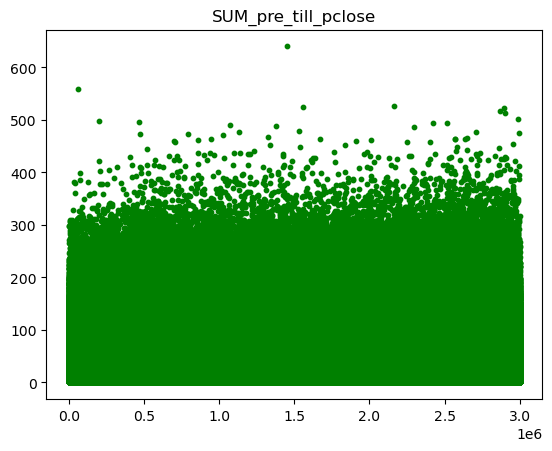

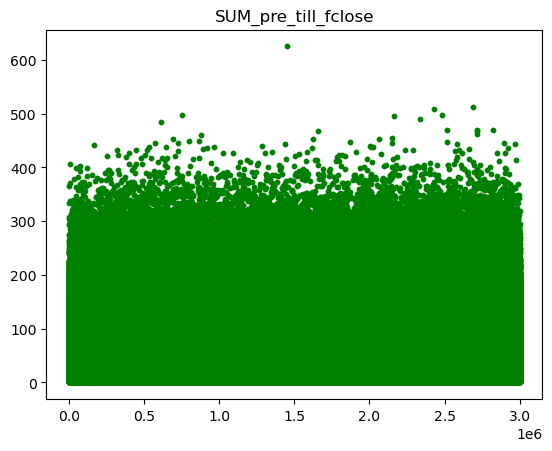

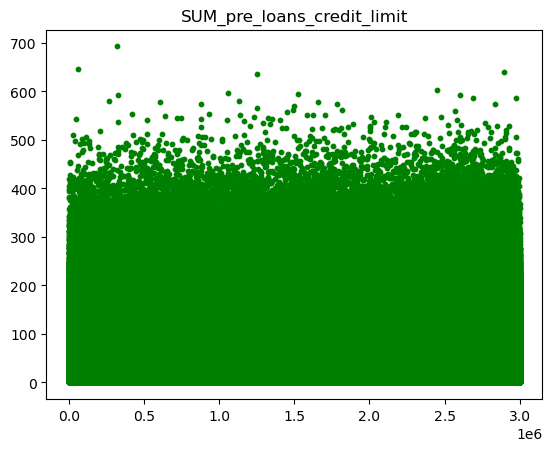

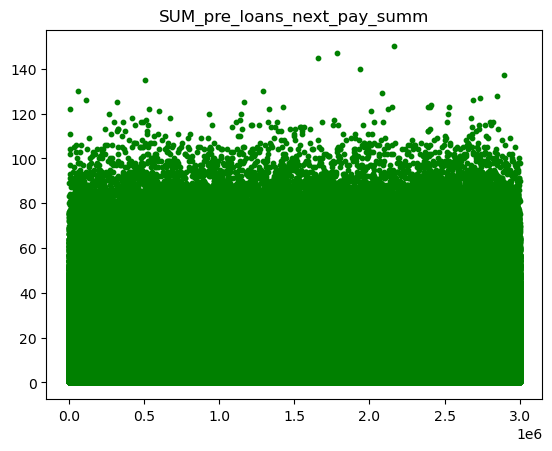

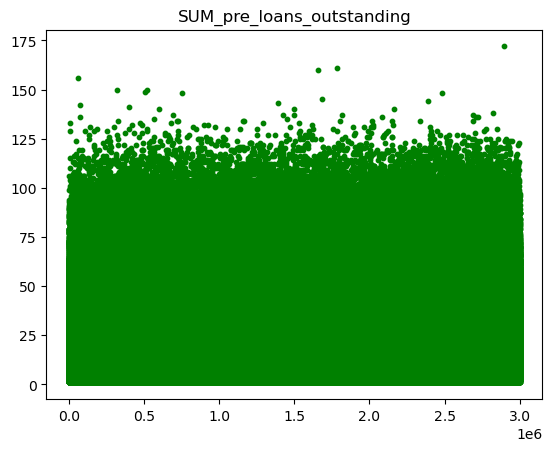

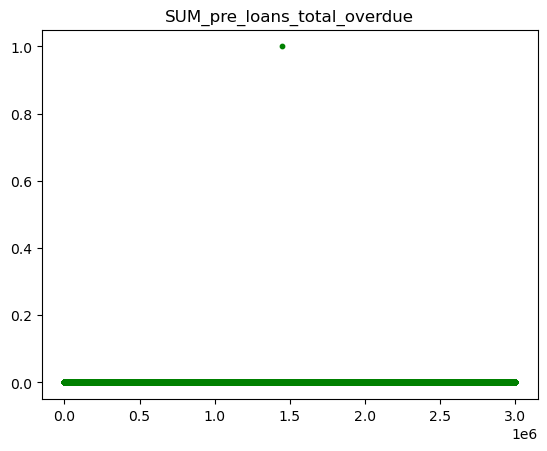

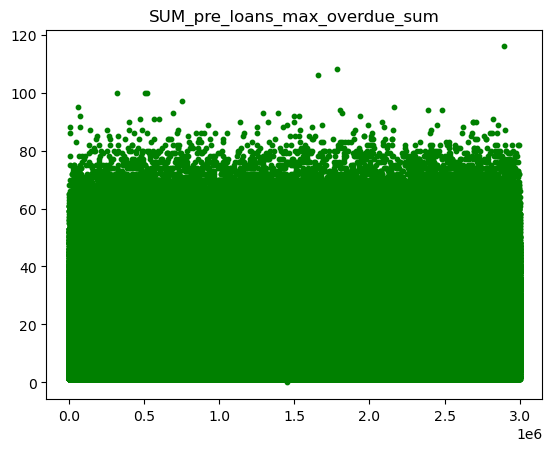

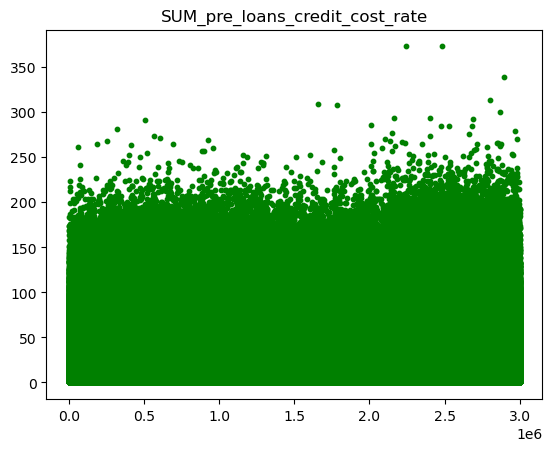

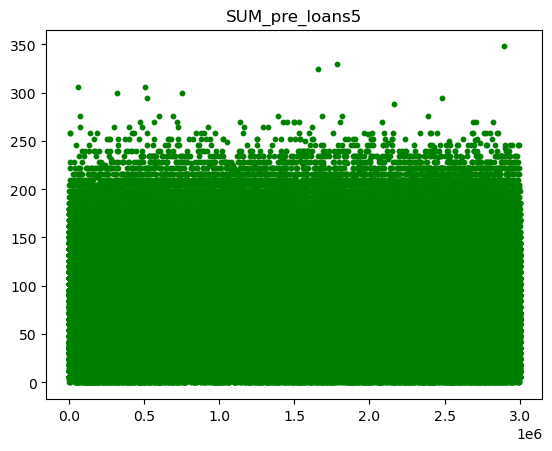

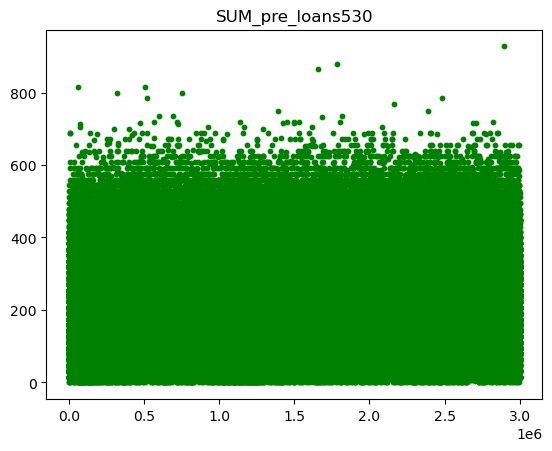

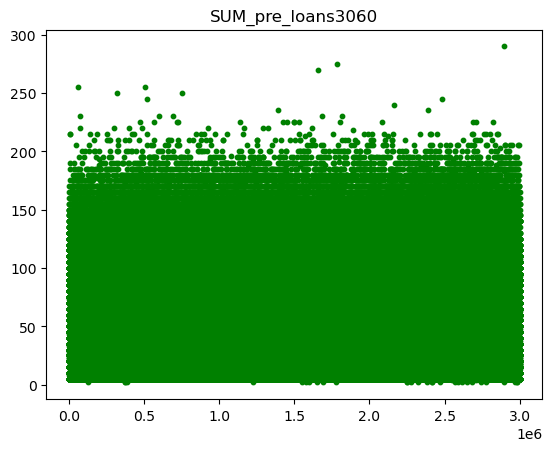

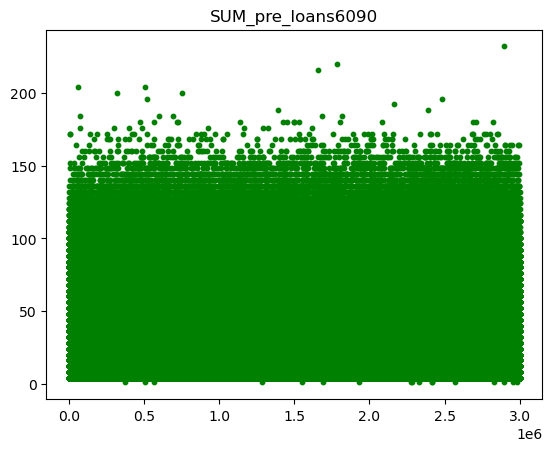

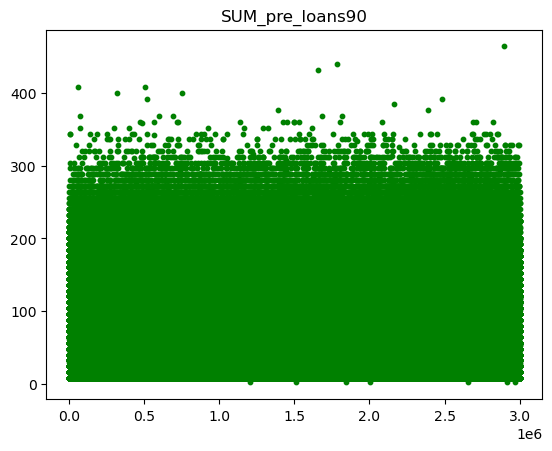

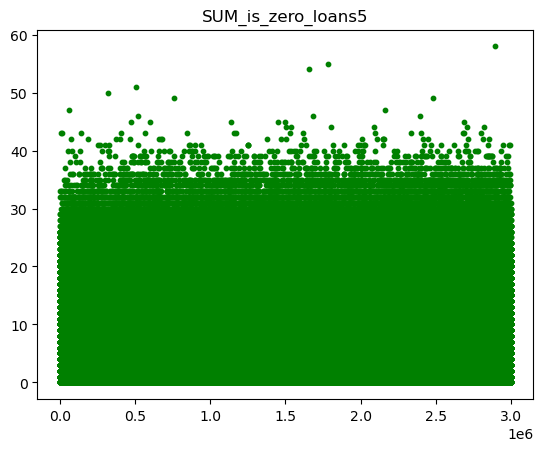

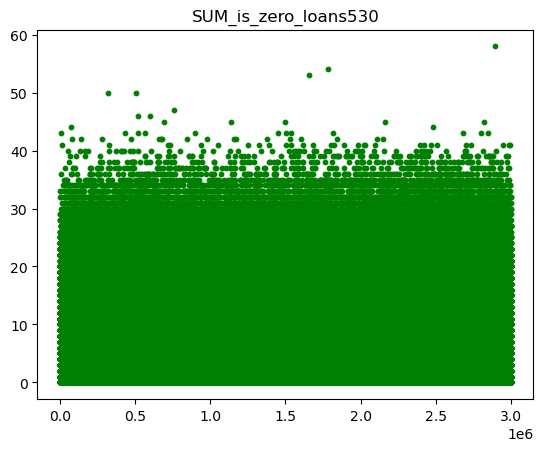

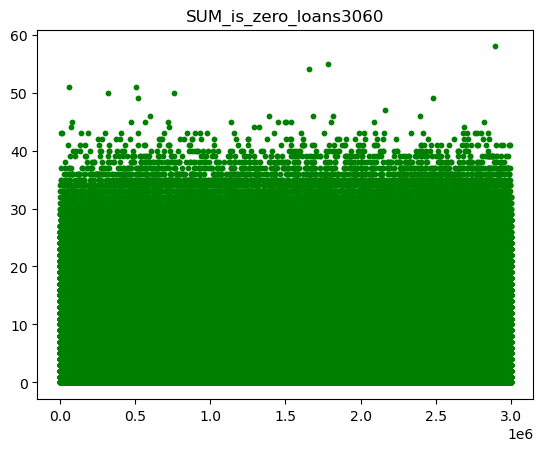

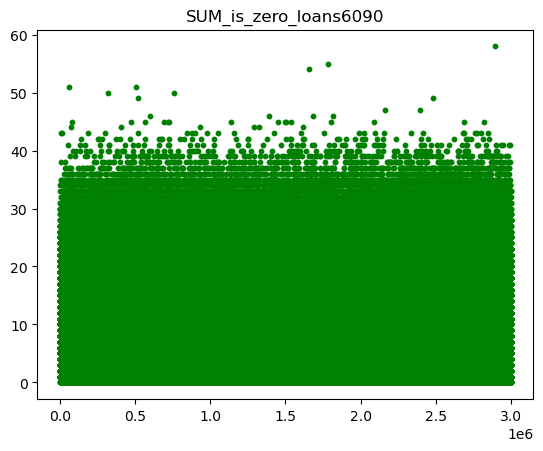

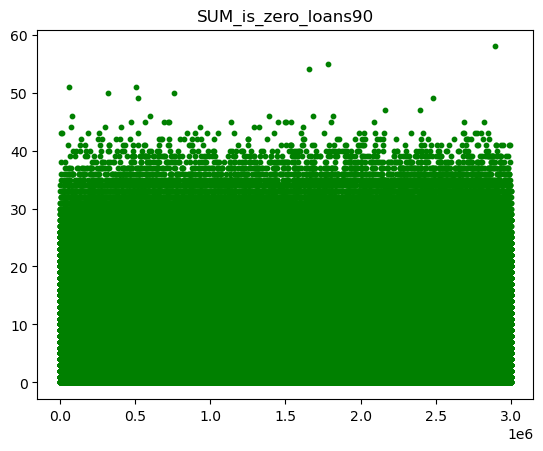

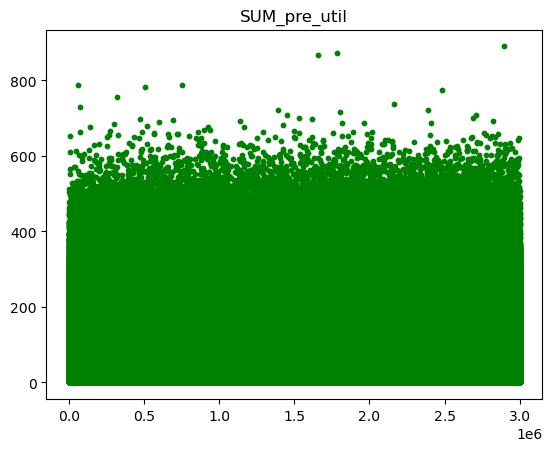

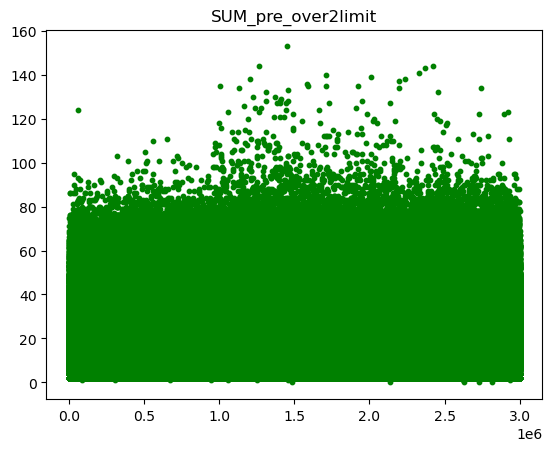

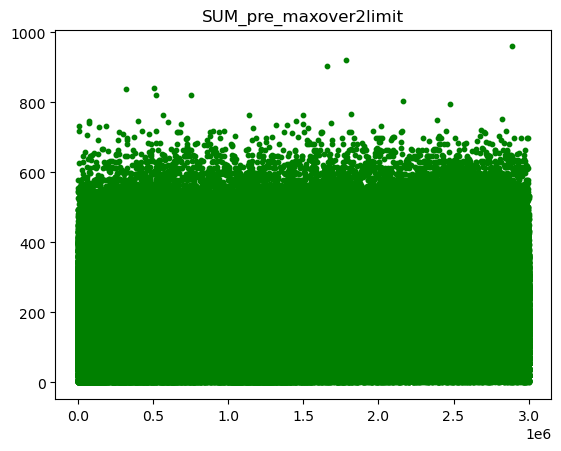

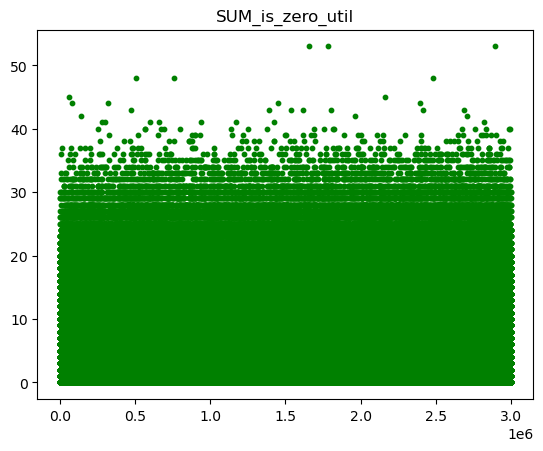

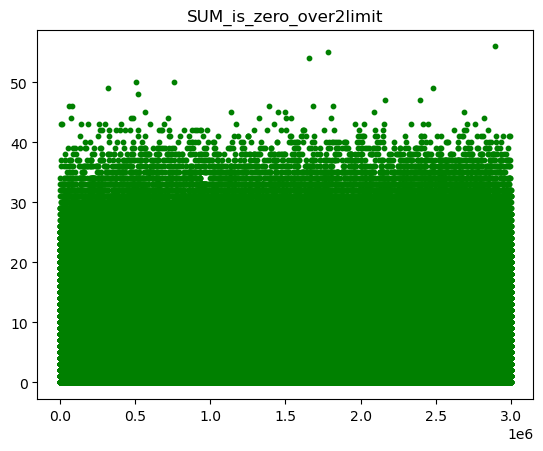

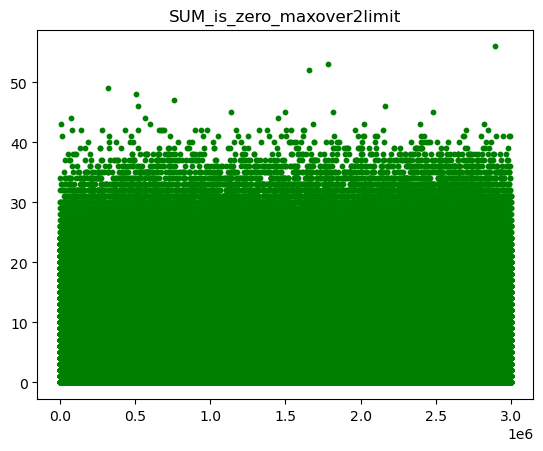

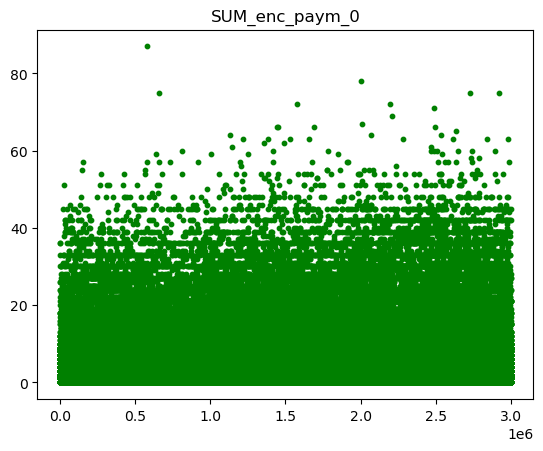

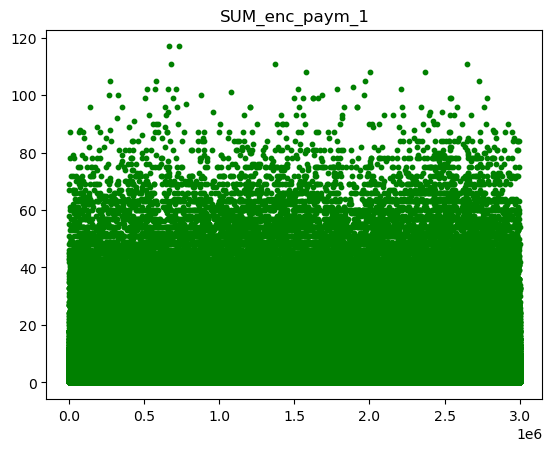

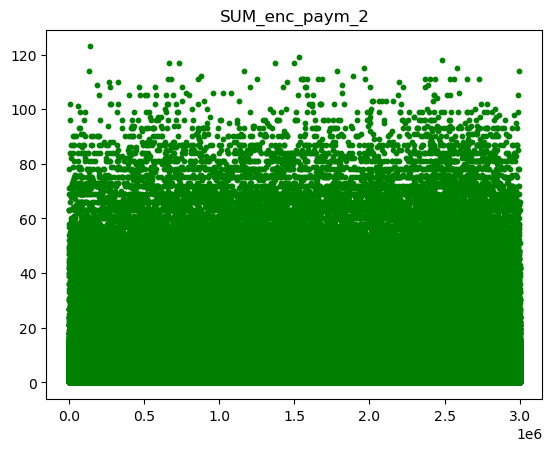

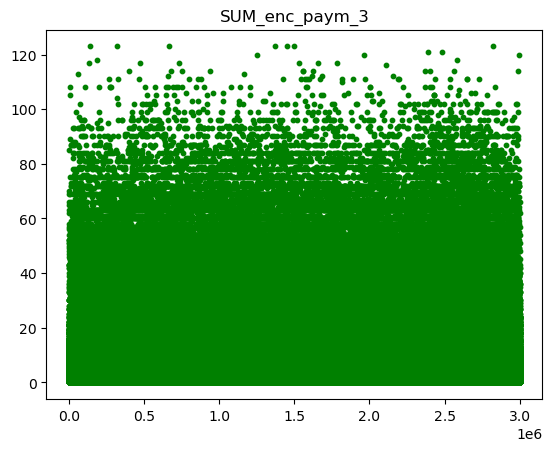

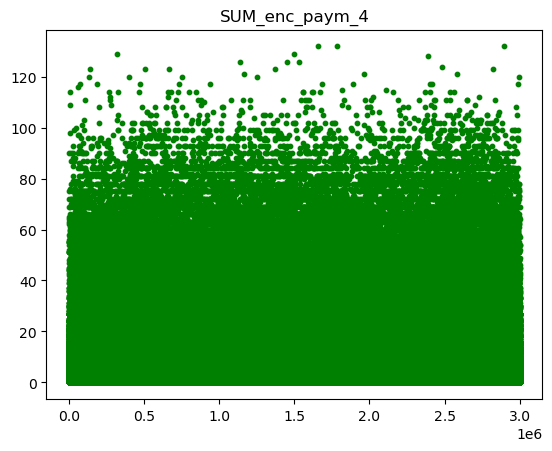

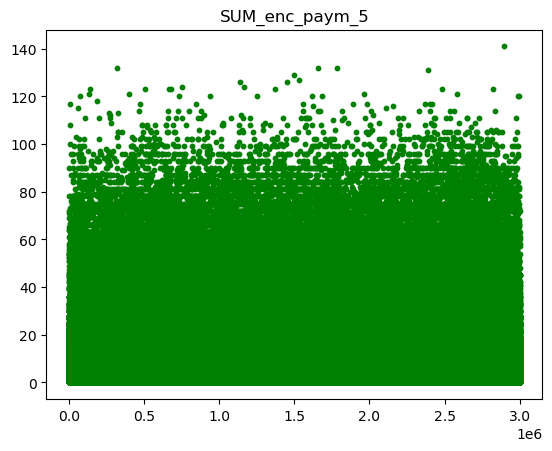

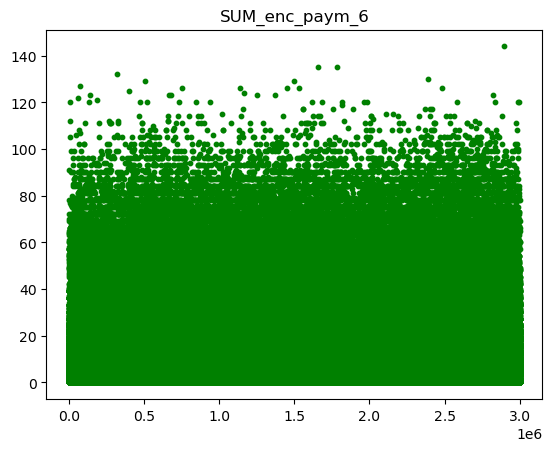

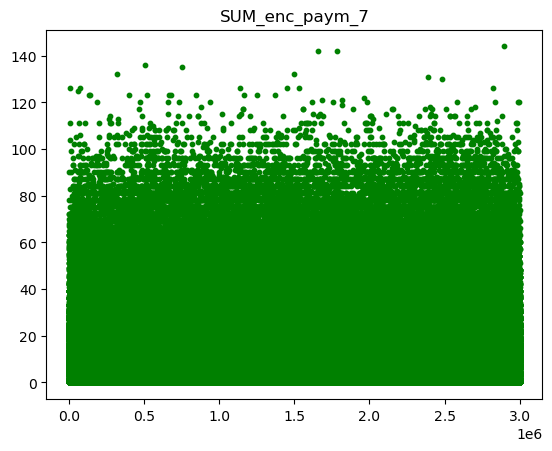

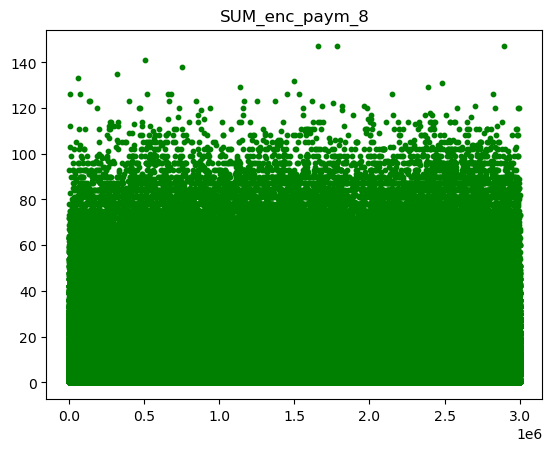

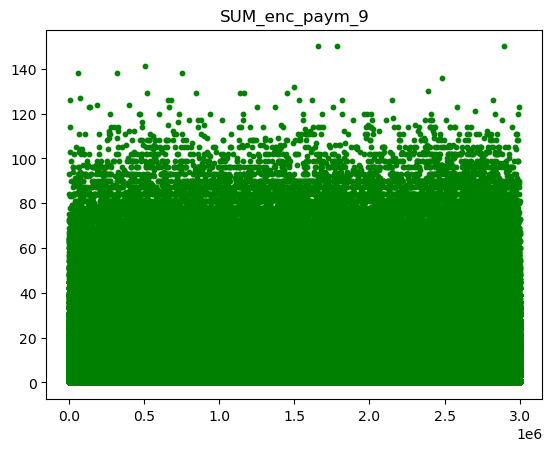

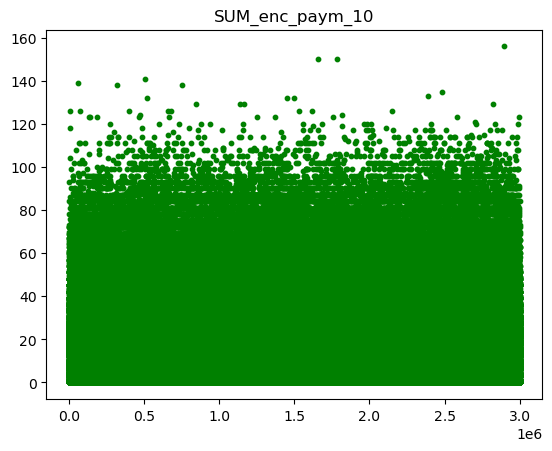

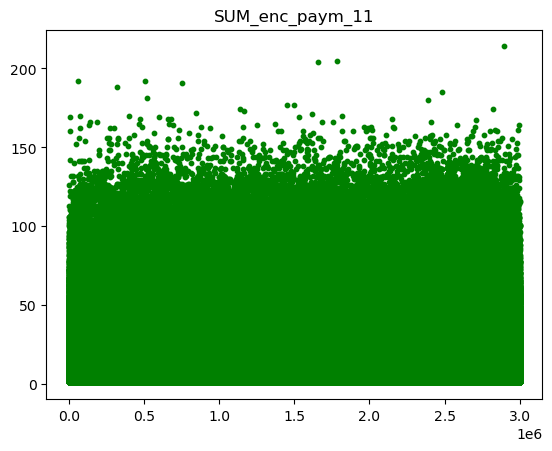

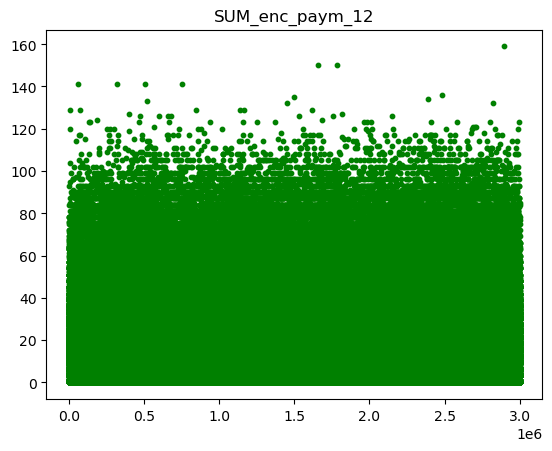

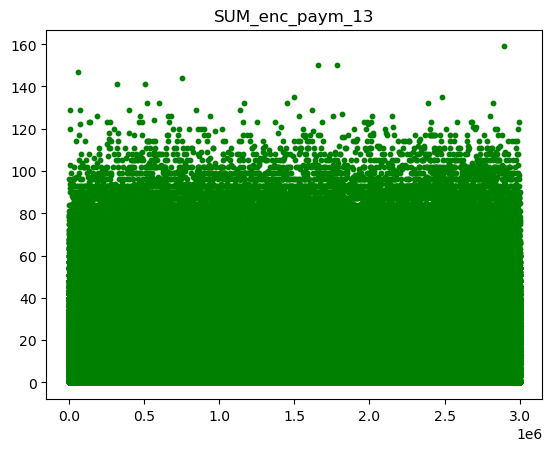

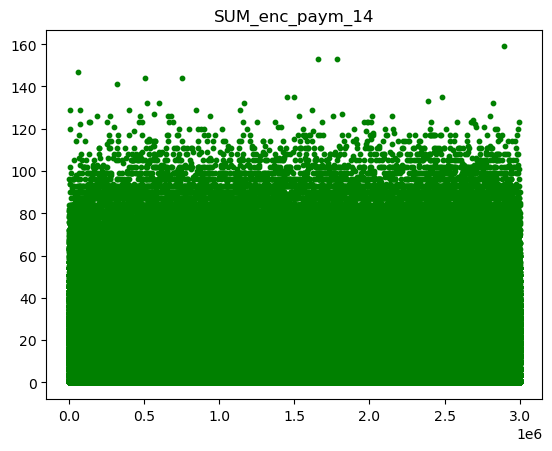

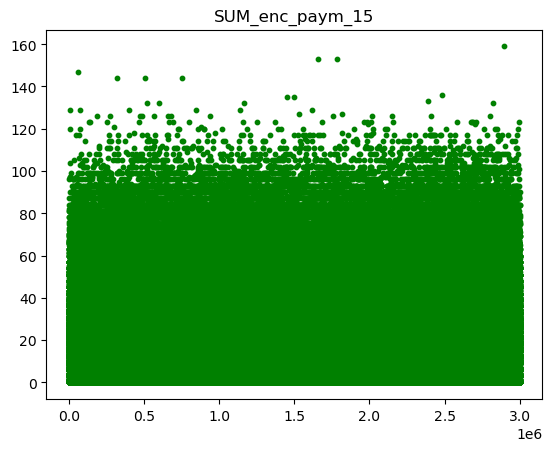

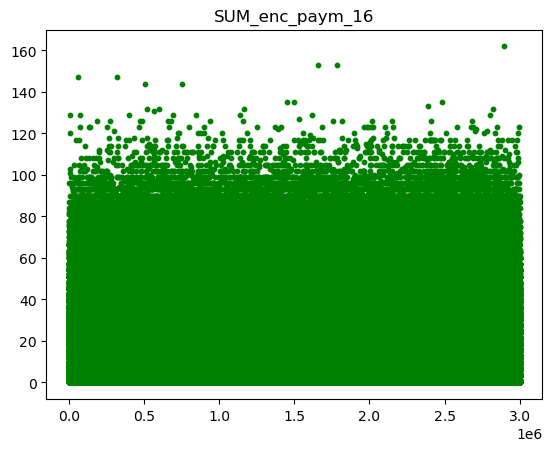

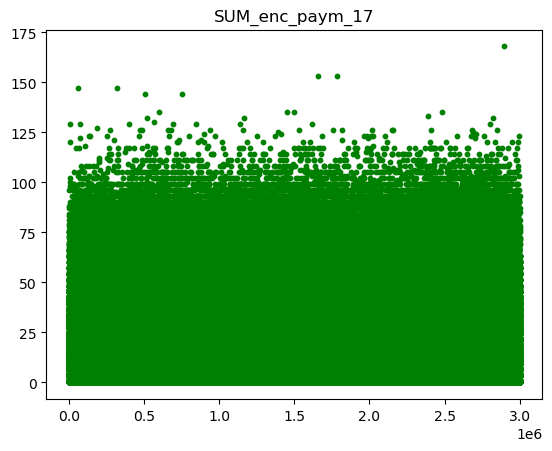

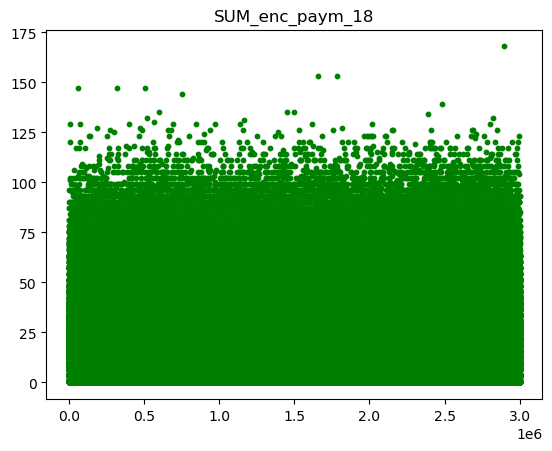

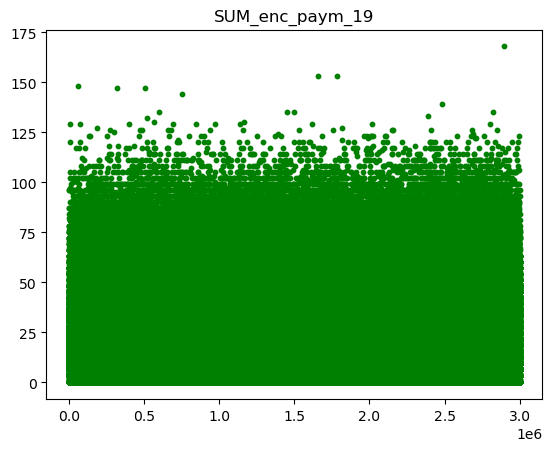

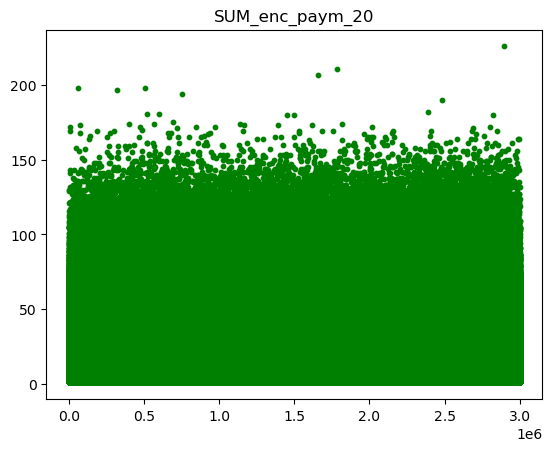

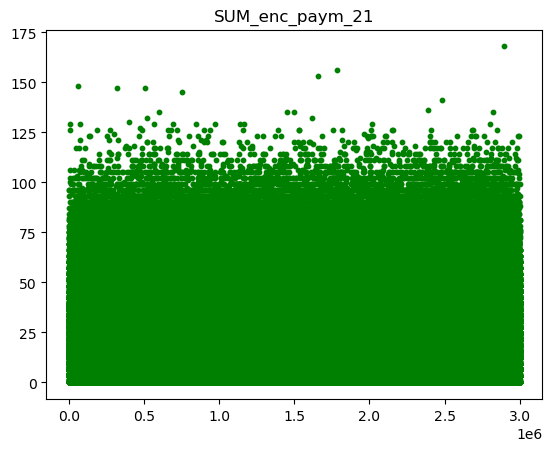

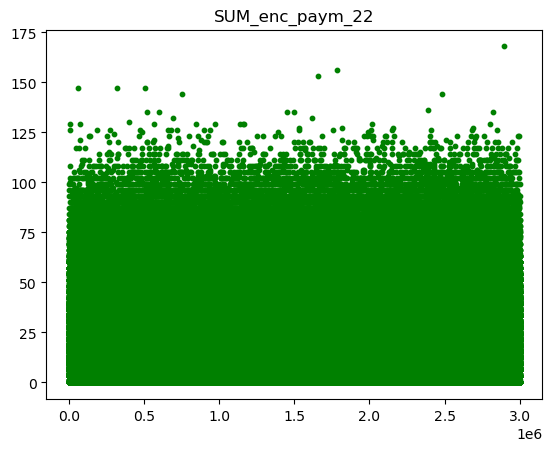

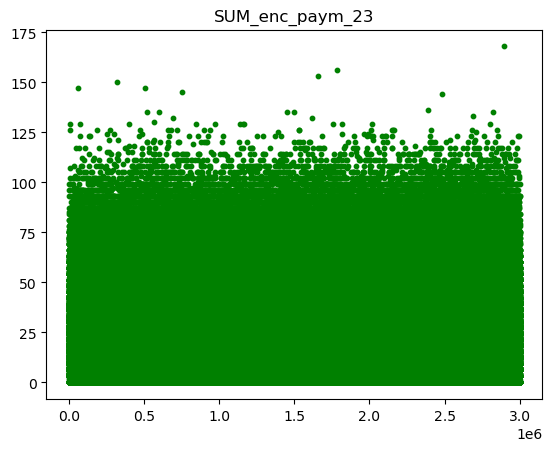

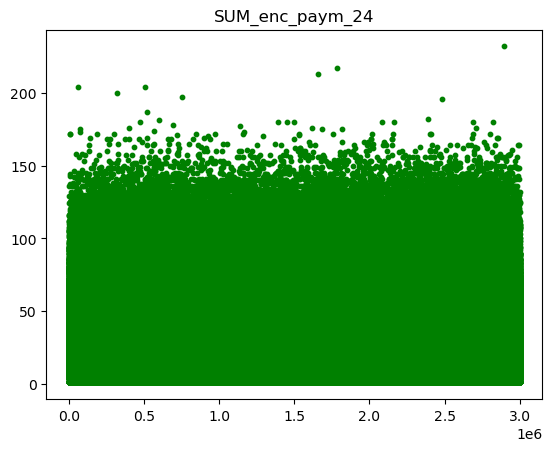

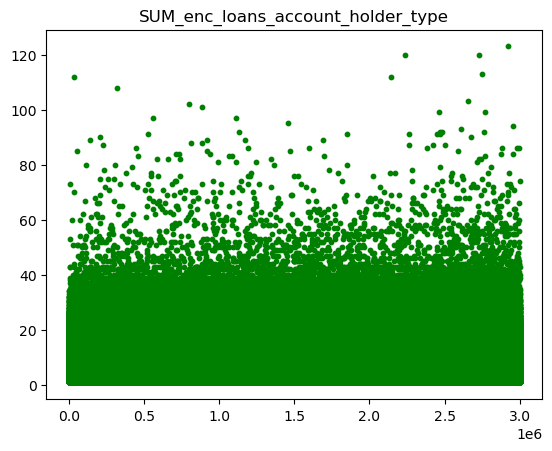

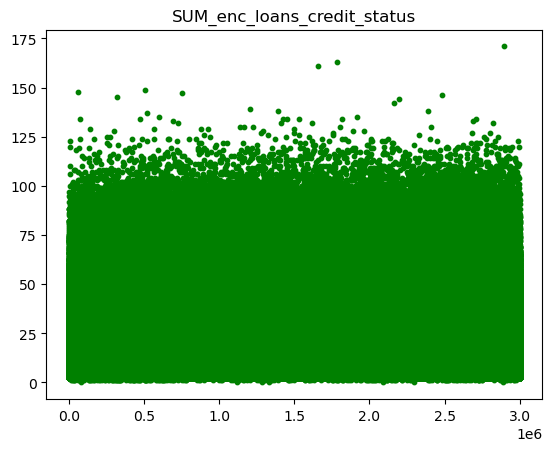

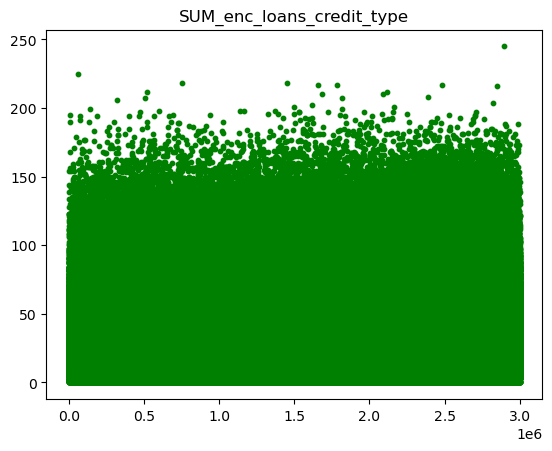

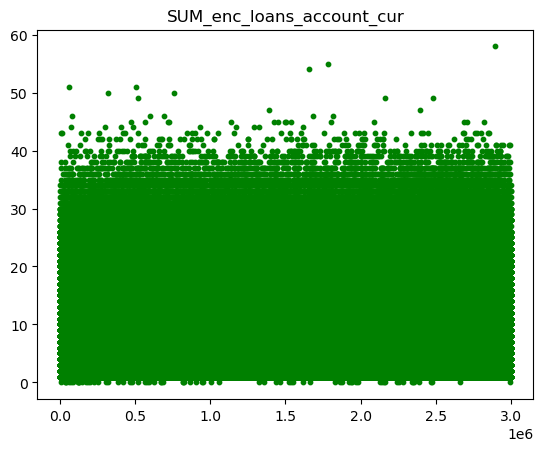

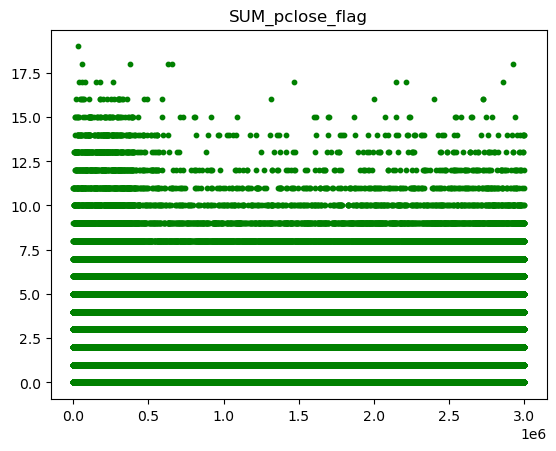

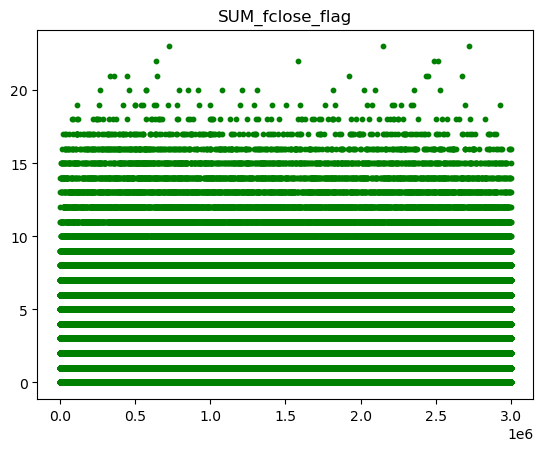

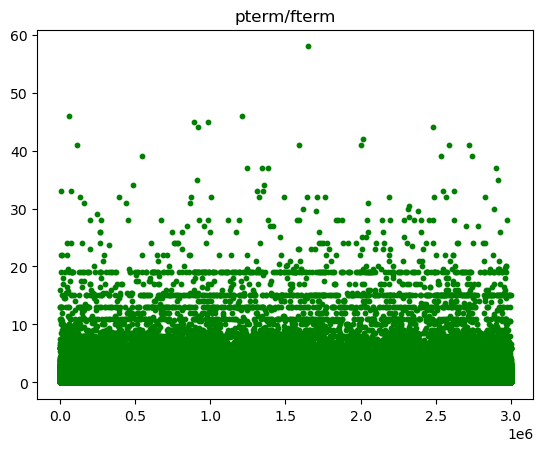

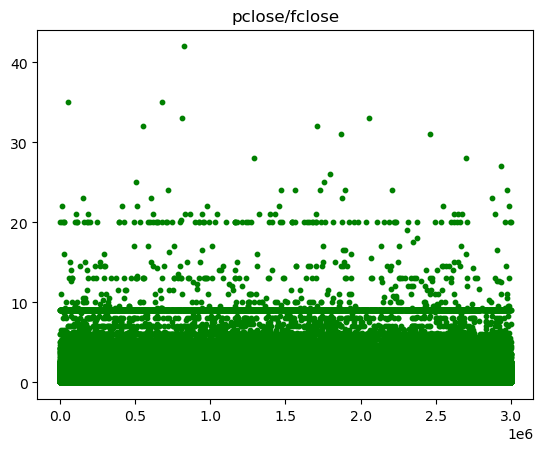

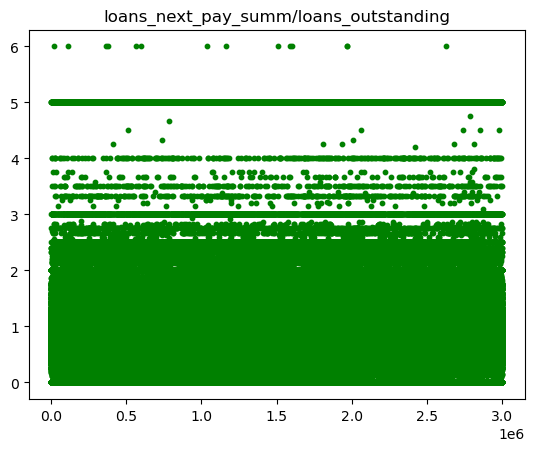

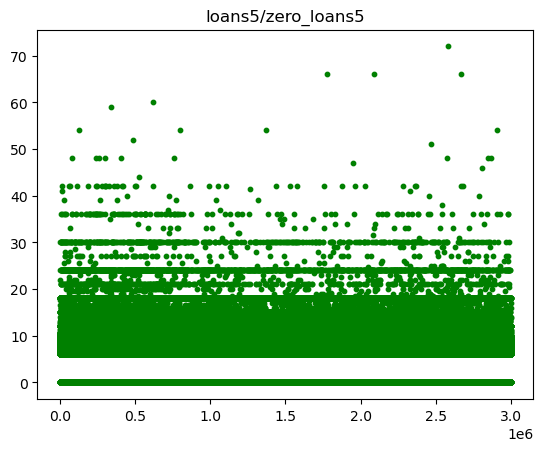

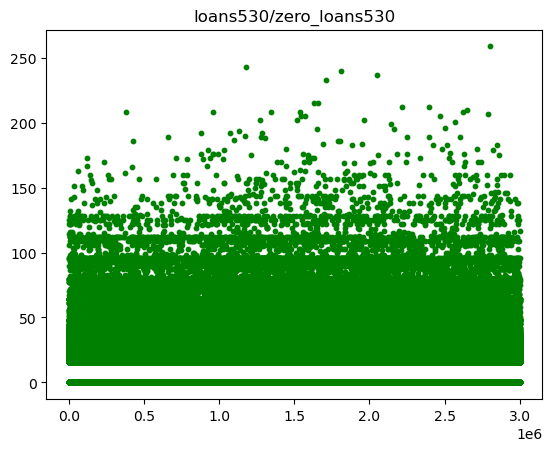

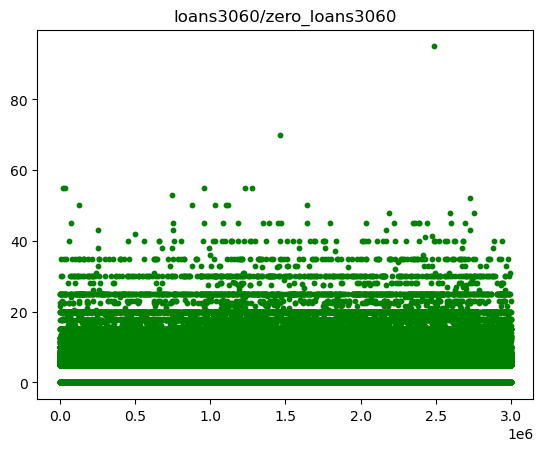

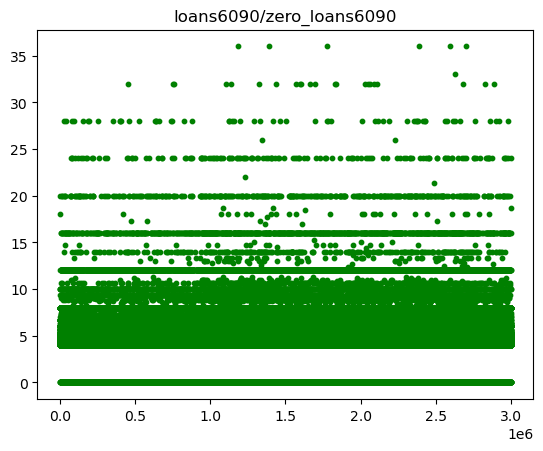

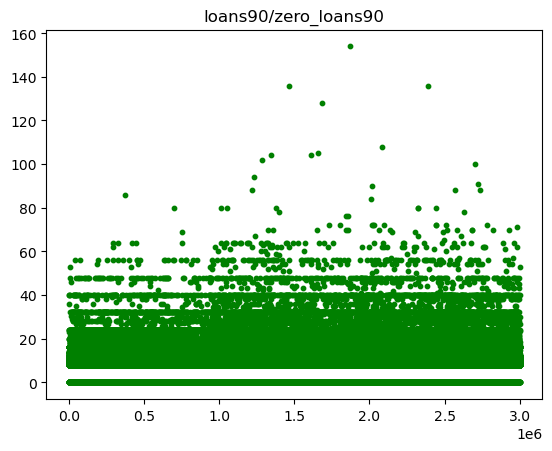

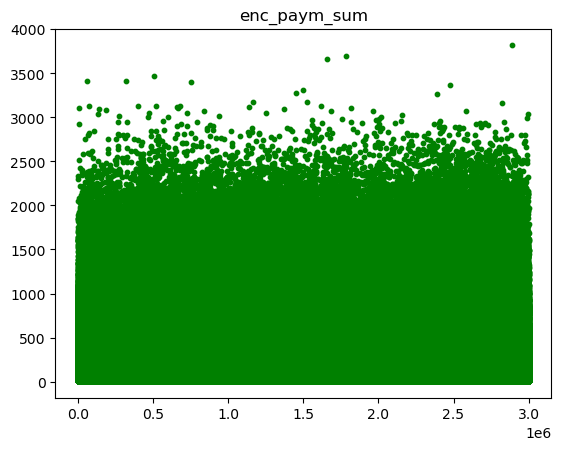

In [35]:
for col in df4.columns:
    plt.scatter(df4.index, df4[col], c='g', s=10)
    plt.title(col)
    plt.show()

# Выявил лишний признак 'SUM_pre_loans_total_overdue'. Имеет одно значение почти во всех строках

In [40]:
df4['SUM_pre_loans_total_overdue'].value_counts()

SUM_pre_loans_total_overdue
0    2999999
1          1
Name: count, dtype: int64

In [41]:
df5 = df4.drop(columns=['SUM_pre_loans_total_overdue', 'id', 'SUM_rn'])

In [42]:
df5.tail()

,flag,SUM_pre_since_opened,SUM_pre_since_confirmed,SUM_pre_pterm,SUM_pre_fterm,SUM_pre_till_pclose,SUM_pre_till_fclose,SUM_pre_loans_credit_limit,SUM_pre_loans_next_pay_summ,SUM_pre_loans_outstanding,...,SUM_fclose_flag,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
2999995,0,97,101,98,98,97,97,81,25,35,...,5,1.000000,1.000000,0.714355,7.332031,34.000000,5.000000,4.0,8.0,359
2999996,0,104,148,117,110,82,89,151,25,40,...,4,1.063477,0.921387,0.625000,6.500000,16.000000,5.417969,4.0,8.0,501
2999997,0,81,78,85,78,82,91,70,24,32,...,1,1.089844,0.900879,0.750000,6.667969,22.859375,5.000000,4.0,8.0,404
2999998,0,58,46,39,47,30,39,57,13,18,...,1,0.829590,0.769043,0.722168,6.000000,16.000000,6.250000,5.0,10.0,332
2999999,0,77,110,92,114,99,105,122,35,33,...,1,0.807129,0.942871,1.060547,6.546875,24.000000,5.453125,4.0,8.0,415


# Решил не применять квантили, так как при стандартных значениях выборка сильно обрезается. Да и на графиках особо нет выбросов.

In [49]:
def quantilecount(dframe):

    dframe2 = dframe.copy()

    for col in dframe.drop(columns='flag'):

        qMin = dframe[col].quantile(0.25)
        qMax = dframe[col].quantile(0.75)
        iqr = qMax - qMin
        bounds = (qMin - iqr*1.5, iqr*1.5 + qMax)

        dframe2 = dframe2[dframe2[col] >= bounds[0]].copy()
        dframe2 = dframe2[dframe2[col] <= bounds[1]].copy()

    return dframe2.reset_index(drop=True)

# Стандартизирую значения во всей таблице, но не целевую переменную

In [71]:
scaler = StandardScaler().fit_transform(df5.drop(columns='flag'))
df6 = pd.DataFrame(data=scaler, columns=df5.drop(columns='flag').columns)
df6 = pd.concat([df5.flag, df6], axis=1)

In [73]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 68 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   flag                                   int8   
 1   SUM_pre_since_opened                   float32
 2   SUM_pre_since_confirmed                float32
 3   SUM_pre_pterm                          float32
 4   SUM_pre_fterm                          float32
 5   SUM_pre_till_pclose                    float32
 6   SUM_pre_till_fclose                    float32
 7   SUM_pre_loans_credit_limit             float32
 8   SUM_pre_loans_next_pay_summ            float32
 9   SUM_pre_loans_outstanding              float32
 10  SUM_pre_loans_max_overdue_sum          float32
 11  SUM_pre_loans_credit_cost_rate         float32
 12  SUM_pre_loans5                         float32
 13  SUM_pre_loans530                       float32
 14  SUM_pre_loans3060                      float32
 15

# Смотрю распределение целевых классов

In [74]:
df6.flag.value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

In [75]:
df6.shape

(3000000, 68)

# Так как имеется дисбаланс в целевой переменной и к тому же, не хватает, по условию задания, 500 тыс. строк до 3-ёх млн, то можно эти 0,5 млн добрать меньшим значением в целевой переменной, апскейлом, просто скопировав несколько раз эти строки. Таким образом уменьшив дисбаланс классов и увеличив значимость меньшего класса

In [94]:
train, test = train_test_split(df6[df6.flag==0], test_size=df6.flag.value_counts()[1]*2, random_state=42)

In [97]:
df7 = pd.concat([test, df6[df6.flag==1]]).reset_index(drop=True)

In [98]:
df7.tail()

,flag,SUM_pre_since_opened,SUM_pre_since_confirmed,SUM_pre_pterm,SUM_pre_fterm,SUM_pre_till_pclose,SUM_pre_till_fclose,SUM_pre_loans_credit_limit,SUM_pre_loans_next_pay_summ,SUM_pre_loans_outstanding,...,SUM_fclose_flag,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
319321,1,0.492060,-0.031913,-0.090494,0.044658,-0.005549,0.097845,-0.053043,-0.176368,0.046824,...,0.001891,-0.231834,-0.133022,-0.432646,1.375470,-0.255344,-0.251266,-0.197121,-0.175611,0.117753
319322,1,-0.659349,-0.718618,-0.747638,-0.906425,-0.575508,-0.828749,-0.679175,-0.716187,-0.705478,...,0.001891,0.326383,0.495473,-0.163007,0.981892,0.189072,-0.251266,-0.197121,-0.175611,-0.861221
319323,1,-0.010668,0.283600,-0.528590,-0.183602,-0.371951,-0.249628,-0.663522,-0.446278,-0.275592,...,1.186687,-0.543415,-0.247129,-0.432646,-0.398325,2.195793,-0.251266,-0.197121,-0.175611,-0.476982
319324,1,0.216371,0.209362,0.019030,-0.754252,-0.209106,-0.384756,0.009570,-0.311323,-0.221856,...,-0.590508,1.763884,0.212016,-0.273430,-0.101794,1.432260,5.821799,4.428176,4.633771,0.318226
319325,1,0.913703,0.951746,0.803951,0.425092,0.421921,0.329493,0.651356,0.700838,0.530446,...,1.186687,0.253413,0.103343,0.079668,-0.053271,-0.312119,-0.251266,-0.197121,-0.175611,0.438509


In [99]:
df7.flag.value_counts()

flag
0    212884
1    106442
Name: count, dtype: int64

In [100]:
emptyval(df7)

Done


In [101]:
infval(df7)

Done


In [102]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319326 entries, 0 to 319325
Data columns (total 68 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   flag                                   319326 non-null  int8   
 1   SUM_pre_since_opened                   319326 non-null  float32
 2   SUM_pre_since_confirmed                319326 non-null  float32
 3   SUM_pre_pterm                          319326 non-null  float32
 4   SUM_pre_fterm                          319326 non-null  float32
 5   SUM_pre_till_pclose                    319326 non-null  float32
 6   SUM_pre_till_fclose                    319326 non-null  float32
 7   SUM_pre_loans_credit_limit             319326 non-null  float32
 8   SUM_pre_loans_next_pay_summ            319326 non-null  float32
 9   SUM_pre_loans_outstanding              319326 non-null  float32
 10  SUM_pre_loans_max_overdue_sum          319326 non-null  

# Applying

# Отбираю лучшую модель с лучшими параметрами которая будет применена в итоговом Pipeline

In [103]:
train, test = train_test_split(df7, test_size=0.02, random_state=42)
xx = test.drop(columns='flag')
yy = test.flag

xtrain, xtest, ytrain, ytest = train_test_split(xx, yy, test_size=0.3, random_state=42)

In [104]:
xtrain.shape

(4470, 67)

### Тестирую RandomForestClassifier

In [105]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
param ={
        'max_depth': [10, 100, 200, None],
        'max_features': ['sqrt', 'log2', None]
        }

RFCGC = GridSearchCV(rfc, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5).fit(xtrain, ytrain)

print(f'best_params_: {RFCGC.best_params_}')
print(f'best_score_: {RFCGC.best_score_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best_params_: {'max_depth': 10, 'max_features': 'sqrt'}
best_score_: 0.6892886280297502


In [106]:
roc_auc_score(ytest, RFCGC.predict_proba(xtest)[:, 1])

0.7018038905787161

### Тестирую SVC

In [ ]:
svc = SVC(probability=True, cache_size=10000)
param ={
        'C': [i for i in np.arange(3, 8)],
        'gamma': ['auto', 'scale'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
       }

SVCGS = GridSearchCV(svc, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5).fit(xtrain, ytrain)

print(f'best_params_: {SVCGS.best_params_}')
print(f'best_score_: {SVCGS.best_score_}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
roc_auc_score(ytest, SVCGS.predict_proba(xtest)[:, 1])

### Тестирую LogisticRegression

In [107]:
lr = LogisticRegression(max_iter=10000)
param ={
        'C': [i for i in np.arange(1, 4)],
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'warm_start': [True, False]
       }

LRGS = GridSearchCV(lr, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5).fit(xtrain, ytrain)

print(f'best_params_: {LRGS.best_params_}')
print(f'best_score_: {LRGS.best_score_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best_params_: {'C': 1, 'solver': 'saga', 'warm_start': True}
best_score_: 0.6862875836762785


In [108]:
roc_auc_score(ytest, LRGS.predict_proba(xtest)[:, 1])

0.7013901314089184

# Pipeline

## Загружаю целевую и признаковые переменные

In [61]:
creditX = pd.DataFrame()
for i in range(12):
  creditX = pd.concat(
                     [creditX,
                      pd.concat(
                                [pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq', columns=['id']),
                                 pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq').drop(columns='id').astype('int8')],
                          axis=1)]
                     )

creditY =  pd.concat(
                     [pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv', usecols=['id']),
                      pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv').drop(columns='id').astype('int8')],
                          axis=1)

## Создаю функции для группировки признаков и соединения их с целевой преременной.
## А также, написал функцию "upscaler", которая шестую часть данных заполняет меньшим классом.

In [83]:
def groupmerge(dframeX, dframeY):
    dframeX2 = dframeX.groupby(['id'], as_index=False).sum().add_prefix('SUM_').reset_index(drop=True)
    dframeX3 = dframeX2.drop(columns='SUM_id').astype('int16')
    dframeX3['id'] = dframeX2.SUM_id
    dframeX3Y = creditY.merge(dframeX3, on='id', how='inner')
    return dframeX3Y


def balancer(dframe):
    train, test = train_test_split(dframe[dframe.flag==0], test_size=dframe.flag.value_counts()[1]*2, random_state=42)
    dframe2 = pd.concat([test, dframe[dframe.flag==1]])
    return dframe2

## Создаю функции для "FunctionTransformer"

In [84]:
def newfeatures(dframe):
    dframe2 = dframe.copy()

    dframe2['pterm/fterm'] = dframe2.SUM_pre_pterm / dframe2.SUM_pre_fterm
    dframe2['pclose/fclose'] = dframe2.SUM_pre_till_pclose / dframe2.SUM_pre_till_fclose
    dframe2['loans_next_pay_summ/loans_outstanding'] = dframe2.SUM_pre_loans_next_pay_summ / dframe2.SUM_pre_loans_outstanding
    dframe2['loans5/zero_loans5'] = dframe2.SUM_pre_loans5 / dframe2.SUM_is_zero_loans5
    dframe2['loans530/zero_loans530'] = dframe2.SUM_pre_loans530 / dframe2.SUM_is_zero_loans530
    dframe2['loans3060/zero_loans3060'] = dframe2.SUM_pre_loans3060 / dframe2.SUM_is_zero_loans3060
    dframe2['loans6090/zero_loans6090'] = dframe2.SUM_pre_loans6090 / dframe2.SUM_is_zero_loans6090
    dframe2['loans90/zero_loans90'] = dframe2.SUM_pre_loans90 / dframe2.SUM_is_zero_loans90

    dframe2['enc_paym_sum'] = dframe2.SUM_enc_paym_0
    for i in range(1, 25):
        dframe2['enc_paym_sum'] = dframe2['enc_paym_sum'] + dframe2[f'SUM_enc_paym_{i}']
    return dframe2


pipe_newfeatures = FunctionTransformer(newfeatures)
############################################################################################


def replacingval(dframe):
    dframe2 = dframe.copy()
    return dframe2.replace([np.inf, -np.inf, np.nan], 0)


pipe_replacingval = FunctionTransformer(replacingval)
############################################################################################


def dropper(dframe):
    dframe2 = dframe.drop(columns=['id', 'SUM_rn', 'SUM_pre_loans_total_overdue'])
    return dframe2


pipe_dropper = FunctionTransformer(dropper)

## Собираю Pipeline на основе лучшей модели с лучшими параметрами.

In [85]:
preparation = Pipeline([
    ('pipe_newfeatures', pipe_newfeatures),
    ('pipe_replacingval', pipe_replacingval),
    ('pipe_dropper', pipe_dropper),
], verbose=True)

columns = make_column_selector(dtype_include=['int64', 'float64'])

coltrans = ColumnTransformer([('transformer', StandardScaler(), columns)], remainder='passthrough')

pipe = Pipeline([
    ('preparation', preparation),
    ('coltrans', coltrans),
    ('SVC', SVC(probability=True, cache_size=10000, C=3, kernel='rbf'))

], verbose=True)

## Применяю на всех данных

In [86]:
CREDIT = groupmerge(creditX, creditY)

In [87]:
trainXY = balancer(CREDIT)

In [88]:
x = trainXY.drop(columns='flag')
y = trainXY.flag

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [89]:
print('train: ',xtrain.shape)
print('test: ',xtest.shape)

train:  (149018, 61)
test:  (63866, 61)


In [90]:
result = pipe.fit(xtrain, ytrain)

[Pipeline] .. (step 1 of 3) Processing pipe_newfeatures, total=   0.1s
[Pipeline] . (step 2 of 3) Processing pipe_replacingval, total=   0.1s
[Pipeline] ...... (step 3 of 3) Processing pipe_dropper, total=   0.0s
[Pipeline] ....... (step 1 of 3) Processing preparation, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing coltrans, total=   0.2s
[Pipeline] .............. (step 3 of 3) Processing SVC, total=375.9min


In [91]:
pred = result.predict(xtest)

In [92]:
confusion_matrix(ytest, pred)

array([[20474, 11333],
       [11345, 20714]], dtype=int64)

In [93]:
roc_auc_score(ytest, result.predict_proba(xtest)[:, 1])

0.6976673588603599

In [ ]:
with open(r'C:\Users\VaL\Downloads\DataScience\Credit\result_pipeline.pkl', 'wb') as dillfile:
    dill.dump(result, dillfile)

In [ ]:
pd.Series(pred).to_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\pred_test.csv', index=False)

# Пришлось снижать глубину леса, так как точность получалась выше 90%, что могло свидетельствовать о переобучении модели.